In [1]:
"""
Improved NNUE Chess Position Evaluator Training Notebook
=========================================================

This notebook trains an advanced neural network to evaluate chess positions.
Improvements over the original:
- Better architecture with residual connections
- Data augmentation
- Mixed precision training
- Enhanced metrics and visualization
- Curriculum learning
- Model ensembling
"""

'\nImproved NNUE Chess Position Evaluator Training Notebook\n=========================================================\n\nThis notebook trains an advanced neural network to evaluate chess positions.\nImprovements over the original:\n- Better architecture with residual connections\n- Data augmentation\n- Mixed precision training\n- Enhanced metrics and visualization\n- Curriculum learning\n- Model ensembling\n'

In [2]:
pip install numpy pandas python-chess torch matplotlib tqdm scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from typing import List, Tuple, Optional, Dict
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Libraries imported successfully!")
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Libraries imported successfully!
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.06 GB


In [12]:
def fen_to_features(fen: str) -> np.ndarray:
    """
    Convert FEN string to piece-square feature vector.

    Features: 768 dimensions = 12 piece types × 64 squares
    Piece order: P, N, B, R, Q, K, p, n, b, r, q, k
    """
    board = chess.Board(fen)
    features = np.zeros(768, dtype=np.float32)

    piece_to_idx = {
        chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
        chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5
    }

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            piece_idx = piece_to_idx[piece.piece_type]
            if not piece.color:  # Black piece
                piece_idx += 6
            feature_idx = piece_idx * 64 + square
            features[feature_idx] = 1.0

    return features


def extract_advanced_features(fen: str) -> np.ndarray:
    """
    Extract additional strategic features beyond piece positions.
    Returns: 16-dimensional feature vector

    Feature breakdown:
    0-1:   Material count (White, Black)
    2-3:   Piece development (White, Black)
    4-5:   King safety (White, Black)
    6-9:   Castling rights (WK, WQ, BK, BQ)
    10-11: Center control (White, Black)
    12:    Mobility (legal moves)
    13:    Turn to move
    14:    In check
    15:    Game phase (opening/middlegame/endgame)
    """
    try:
        board = chess.Board(fen)
        features = []

        # Material count for each side (2 features: 0-1)
        piece_values = {
            chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
            chess.ROOK: 5, chess.QUEEN: 9
        }

        for color in [chess.WHITE, chess.BLACK]:
            material = sum(len(board.pieces(pt, color)) * val
                          for pt, val in piece_values.items())
            features.append(material / 39.0)  # Normalize (max material = 39)

        # Piece development (knights and bishops off back rank) (2 features: 2-3)
        for color in [chess.WHITE, chess.BLACK]:
            back_rank = 0 if color == chess.WHITE else 7
            developed = 0
            for piece_type in [chess.KNIGHT, chess.BISHOP]:
                for square in board.pieces(piece_type, color):
                    if chess.square_rank(square) != back_rank:
                        developed += 1
            features.append(developed / 4.0)  # Normalize (max = 4)

        # King safety (pawns near king) (2 features: 4-5)
        for color in [chess.WHITE, chess.BLACK]:
            king_square = board.king(color)
            if king_square is not None:
                king_file = chess.square_file(king_square)
                king_rank = chess.square_rank(king_square)
                pawns_near = 0

                for df in [-1, 0, 1]:
                    for dr in [-1, 0, 1]:
                        f, r = king_file + df, king_rank + dr
                        if 0 <= f < 8 and 0 <= r < 8:
                            sq = chess.square(f, r)
                            piece = board.piece_at(sq)
                            if piece and piece.piece_type == chess.PAWN and piece.color == color:
                                pawns_near += 1
                features.append(pawns_near / 8.0)
            else:
                features.append(0.0)

        # Castling rights (4 features: 6-9)
        features.append(float(board.has_kingside_castling_rights(chess.WHITE)))
        features.append(float(board.has_queenside_castling_rights(chess.WHITE)))
        features.append(float(board.has_kingside_castling_rights(chess.BLACK)))
        features.append(float(board.has_queenside_castling_rights(chess.BLACK)))

        # Center control (2 features: 10-11)
        center_squares = [chess.E4, chess.E5, chess.D4, chess.D5]
        for color in [chess.WHITE, chess.BLACK]:
            control = sum(1 for sq in center_squares if board.is_attacked_by(color, sq))
            features.append(control / 4.0)

        # Mobility (legal moves count) (1 feature: 12)
        features.append(min(board.legal_moves.count() / 50.0, 1.0))

        # Turn to move (1 feature: 13)
        features.append(float(board.turn))

        # In check (1 feature: 14)
        features.append(float(board.is_check()))

        # Game phase (1 feature: 15)
        # Estimate based on material: opening (>24), middlegame (12-24), endgame (<12)
        total_material = sum(len(board.pieces(pt, chess.WHITE)) * val
                           for pt, val in piece_values.items())
        total_material += sum(len(board.pieces(pt, chess.BLACK)) * val
                            for pt, val in piece_values.items())
        game_phase = min(total_material / 30.0, 1.0)  # Normalize
        features.append(game_phase)

        # Ensure exactly 16 features
        assert len(features) == 16, f"Expected 16 features, got {len(features)}"

        return np.array(features, dtype=np.float32)

    except Exception as e:
        # Return zeros if extraction fails
        print(f"Warning: Failed to extract advanced features for FEN: {fen[:50]}... Error: {e}")
        return np.zeros(16, dtype=np.float32)


def augment_position(fen: str) -> str:
    """Mirror position horizontally for data augmentation."""
    board = chess.Board(fen)
    flipped = chess.Board(None)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            file = chess.square_file(square)
            rank = chess.square_rank(square)
            new_file = 7 - file
            new_square = chess.square(new_file, rank)
            flipped.set_piece_at(new_square, piece)

    flipped.turn = board.turn
    flipped.castling_rights = board.castling_rights

    return flipped.fen()


def eval_to_score(centipawns: float, k: float = 1/400) -> float:
    """Convert centipawn evaluation to win probability [0, 1]."""
    cp = centipawns * 100
    return 1 / (1 + 10**(-k * cp))


# Test feature extraction
print("\nTesting feature extraction:")
test_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
basic_features = fen_to_features(test_fen)
advanced_features = extract_advanced_features(test_fen)
print(f"Basic features shape: {basic_features.shape}")
print(f"Advanced features shape: {advanced_features.shape}")
print(f"Total active pieces: {int(basic_features.sum())}")
print(f"Sample advanced features: {advanced_features[:5]}")

# Test with a few more positions to ensure robustness
print("\nTesting multiple positions:")
test_positions = [
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1",
    "r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3",
    "8/8/8/4k3/8/8/4K3/8 w - - 0 1",
]

for i, fen in enumerate(test_positions):
    try:
        basic = fen_to_features(fen)
        advanced = extract_advanced_features(fen)
        combined = np.concatenate([basic, advanced])
        print(f"  Position {i+1}: {basic.shape[0]} + {advanced.shape[0]} = {combined.shape[0]} features ✓")
    except Exception as e:
        print(f"  Position {i+1}: ERROR - {e}")


Testing feature extraction:
Basic features shape: (768,)
Advanced features shape: (16,)
Total active pieces: 32
Sample advanced features: [1.    1.    0.    0.    0.375]

Testing multiple positions:
  Position 1: 768 + 16 = 784 features ✓
  Position 2: 768 + 16 = 784 features ✓
  Position 3: 768 + 16 = 784 features ✓


In [13]:
class ResidualBlock(nn.Module):
    """Residual block with batch normalization."""
    def __init__(self, in_features, out_features, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Skip connection with dimension matching
        self.skip = nn.Linear(in_features, out_features) if in_features != out_features else None

    def forward(self, x):
        identity = x

        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)

        if self.skip is not None:
            identity = self.skip(identity)

        out += identity
        out = self.relu(out)
        return out


class ImprovedNNUE(nn.Module):
    """
    Improved NNUE architecture with:
    - Residual connections
    - Batch normalization
    - Optional advanced features
    """
    def __init__(self, use_advanced_features=True):
        super(ImprovedNNUE, self).__init__()
        self.use_advanced_features = use_advanced_features

        # Input layer
        input_size = 768 + (16 if use_advanced_features else 0)
        self.input_layer = nn.Linear(input_size, 512)
        self.input_bn = nn.BatchNorm1d(512)

        # Residual blocks
        self.res_block1 = ResidualBlock(512, 384, dropout=0.15)
        self.res_block2 = ResidualBlock(384, 256, dropout=0.15)
        self.res_block3 = ResidualBlock(256, 128, dropout=0.1)

        # Output layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initial transformation
        x = self.input_layer(x)
        x = self.input_bn(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # Output layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)


# Test model
print("\nModel Architecture:")
model = ImprovedNNUE(use_advanced_features=True).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
ImprovedNNUE(
  (input_layer): Linear(in_features=784, out_features=512, bias=True)
  (input_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block1): ResidualBlock(
    (fc1): Linear(in_features=512, out_features=384, bias=True)
    (bn1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=384, out_features=384, bias=True)
    (bn2): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.15, inplace=False)
    (skip): Linear(in_features=512, out_features=384, bias=True)
  )
  (res_block2): ResidualBlock(
    (fc1): Linear(in_features=384, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [14]:
class ChessDataset(Dataset):
    """Enhanced PyTorch dataset with data augmentation."""

    def __init__(self, positions: List[Tuple[str, float]],
                 use_advanced_features=True, augment=False):
        self.positions = positions
        self.use_advanced_features = use_advanced_features
        self.augment = augment

        # Validate feature dimensions on first item
        if len(positions) > 0:
            test_fen, _ = positions[0]
            test_basic = fen_to_features(test_fen)
            assert test_basic.shape == (768,), f"Expected 768 basic features, got {test_basic.shape}"

            if use_advanced_features:
                test_advanced = extract_advanced_features(test_fen)
                assert test_advanced.shape == (16,), f"Expected 16 advanced features, got {test_advanced.shape}"
                print(f"✓ Dataset initialized: 768 basic + 16 advanced = 784 features per position")
            else:
                print(f"✓ Dataset initialized: 768 basic features per position")

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        fen, eval_pawns = self.positions[idx]

        # Data augmentation: 50% chance to mirror position
        if self.augment and np.random.random() < 0.5:
            try:
                fen = augment_position(fen)
                eval_pawns = -eval_pawns  # Flip evaluation
            except:
                pass  # If augmentation fails, use original

        # Extract features
        basic_features = fen_to_features(fen)

        if self.use_advanced_features:
            advanced_features = extract_advanced_features(fen)
            features = np.concatenate([basic_features, advanced_features])
        else:
            features = basic_features

        # Validate shape before returning
        expected_size = 784 if self.use_advanced_features else 768
        if features.shape[0] != expected_size:
            raise ValueError(f"Feature shape mismatch! Expected {expected_size}, got {features.shape[0]} for FEN: {fen[:50]}...")

        # Convert evaluation to score
        score = eval_to_score(eval_pawns)

        # Convert to tensors
        features = torch.from_numpy(features).float()
        score = torch.tensor([score], dtype=torch.float32)

        return features, score


def should_keep_position(fen: str, eval_pawns: float, move_number: int = None) -> bool:
    """Enhanced position filtering."""
    # Filter extreme evaluations
    if abs(eval_pawns) > 8.0:
        return False

    # Count pieces
    board = chess.Board(fen)
    piece_count = len(board.piece_map())

    # Skip very simple endgames
    if piece_count < 6:
        return False

    # Skip very early opening
    if move_number is not None and move_number < 8:
        return False

    # Skip positions with too few legal moves (forced sequences)
    if board.legal_moves.count() < 3:
        return False

    return True


def load_and_filter_csv(csv_file: str,
                        max_positions: Optional[int] = None,
                        sample_frac: Optional[float] = None) -> List[Tuple[str, float]]:
    """Load and filter positions from CSV."""
    print(f"Loading CSV file: {csv_file}")

    df = pd.read_csv(csv_file, engine="python", on_bad_lines="skip")
    print(f"Loaded {len(df):,} positions from CSV")

    if sample_frac is not None:
        print(f"Sampling {sample_frac*100}% of data...")
        df = df.sample(frac=sample_frac, random_state=42)
        print(f"Sampled down to {len(df):,} positions")

    print("Applying filters...")
    initial_count = len(df)

    filtered_positions = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Filtering positions"):
        fen = row['fen']
        eval_pawns = row['evaluation']

        if should_keep_position(fen, eval_pawns):
            filtered_positions.append((fen, eval_pawns))

            if max_positions and len(filtered_positions) >= max_positions:
                break

    filtered_count = len(filtered_positions)
    removed_count = initial_count - filtered_count
    removal_pct = (removed_count / initial_count) * 100 if initial_count > 0 else 0

    print(f"\nFiltering results:")
    print(f"  Initial: {initial_count:,}")
    print(f"  Filtered: {filtered_count:,}")
    print(f"  Removed: {removed_count:,} ({removal_pct:.1f}%)")

    evals = [e for _, e in filtered_positions]
    print(f"\nEvaluation distribution:")
    print(f"  Min: {min(evals):.2f}, Max: {max(evals):.2f}")
    print(f"  Mean: {np.mean(evals):.2f}, Std: {np.std(evals):.2f}")
    print(f"  Median: {np.median(evals):.2f}")

    return filtered_positions


def balance_dataset(positions: List[Tuple[str, float]],
                   bins: int = 10) -> List[Tuple[str, float]]:
    """Balance dataset across evaluation ranges."""
    df = pd.DataFrame(positions, columns=['fen', 'eval'])
    df['bin'] = pd.cut(df['eval'], bins=bins, labels=False)

    min_size = df['bin'].value_counts().min()
    balanced = df.groupby('bin', group_keys=False).apply(
        lambda x: x.sample(min(len(x), min_size), random_state=42)
    )

    print(f"\nDataset balancing:")
    print(f"  Original: {len(df):,} positions")
    print(f"  Balanced: {len(balanced):,} positions")
    print(f"  Distribution across {bins} bins:")
    print(balanced['bin'].value_counts().sort_index())

    return list(zip(balanced['fen'], balanced['eval']))

In [15]:
class WarmupScheduler:
    """Learning rate warmup scheduler."""
    def __init__(self, optimizer, warmup_epochs, base_lr, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.current_epoch = 0

    def step(self):
        if self.current_epoch < self.warmup_epochs:
            lr = self.min_lr + (self.base_lr - self.min_lr) * (self.current_epoch / self.warmup_epochs)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_epoch += 1
        return self.optimizer.param_groups[0]['lr']


def calculate_metrics(model, data_loader, device='cuda'):
    """Calculate comprehensive evaluation metrics."""
    model.eval()
    errors = []
    predictions = []
    actuals = []

    with torch.no_grad():
        for features, targets in tqdm(data_loader, desc="Calculating metrics", leave=False):
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
            errors.extend(torch.abs(outputs - targets).cpu().numpy().flatten())

    errors = np.array(errors)
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    return {
        'mae': np.mean(errors),
        'rmse': np.sqrt(np.mean(errors ** 2)),
        'median_error': np.median(errors),
        'max_error': np.max(errors),
        'accuracy_5': np.mean(errors < 0.05) * 100,
        'accuracy_10': np.mean(errors < 0.10) * 100,
        'accuracy_20': np.mean(errors < 0.20) * 100,
        'correlation': np.corrcoef(predictions, actuals)[0, 1]
    }


def train_model_advanced(model, train_loader, val_loader,
                        epochs=30, lr=0.001, warmup_epochs=3,
                        use_mixed_precision=True, device='cuda'):
    """
    Advanced training with:
    - Mixed precision training
    - Learning rate warmup
    - Gradient clipping
    - Early stopping
    """
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    # Learning rate schedulers
    warmup = WarmupScheduler(optimizer, warmup_epochs, lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3,
    )

    # Mixed precision training
    scaler = GradScaler() if use_mixed_precision else None

    history = {
        'train_loss': [], 'val_loss': [],
        'train_mae': [], 'val_mae': [],
        'learning_rate': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 7

    for epoch in range(epochs):
        # Warmup learning rate
        if epoch < warmup_epochs:
            current_lr = warmup.step()
        else:
            current_lr = optimizer.param_groups[0]['lr']

        history['learning_rate'].append(current_lr)

        # Training phase
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        train_batches = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for features, targets in train_pbar:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(features)
                    loss = criterion(outputs, targets)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(features)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            train_loss += loss.item()
            train_mae += torch.mean(torch.abs(outputs - targets)).item()
            train_batches += 1

            train_pbar.set_postfix({'loss': loss.item(), 'lr': current_lr})

        train_loss /= train_batches
        train_mae /= train_batches

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_batches = 0

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]  ')

        with torch.no_grad():
            for features, targets in val_pbar:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(outputs - targets)).item()
                val_batches += 1

                val_pbar.set_postfix({'loss': loss.item()})

        val_loss /= val_batches
        val_mae /= val_batches

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        # Learning rate scheduling
        if epoch >= warmup_epochs:
            scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'best_nnue_model.pth')
            print(f'✓ Saved best model (val_loss: {val_loss:.6f}, val_mae: {val_mae:.6f})')
            patience_counter = 0
        else:
            patience_counter += 1

        print(f'Epoch {epoch+1}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}, '
              f'train_mae={train_mae:.6f}, val_mae={val_mae:.6f}, lr={current_lr:.6f}')

        # Early stopping
        if patience_counter >= max_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    return history

In [16]:
def plot_training_history_advanced(history):
    """Create comprehensive training visualization."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Training Loss', marker='o', markersize=4)
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # MAE curves
    axes[0, 1].plot(history['train_mae'], label='Training MAE', marker='o', markersize=4)
    axes[0, 1].plot(history['val_mae'], label='Validation MAE', marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Mean Absolute Error')
    axes[0, 1].set_title('Training and Validation MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate
    axes[1, 0].plot(history['learning_rate'], marker='o', markersize=4, color='orange')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Loss difference
    loss_diff = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 1].plot(loss_diff, marker='o', markersize=4, color='red')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Loss - Training Loss')
    axes[1, 1].set_title('Overfitting Monitor')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history_advanced.png', dpi=150)
    plt.show()
    print("Training history plot saved as 'training_history_advanced.png'")


def plot_error_distribution(model, test_loader, device='cuda'):
    """Visualize error distribution."""
    model.eval()
    errors = []

    with torch.no_grad():
        for features, targets in tqdm(test_loader, desc="Calculating errors", leave=False):
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            batch_errors = torch.abs(outputs - targets).cpu().numpy().flatten()
            errors.extend(batch_errors)

    errors = np.array(errors)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram
    axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
    axes[0].axvline(np.median(errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(errors):.4f}')
    axes[0].set_xlabel('Absolute Error')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Error Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Cumulative distribution
    sorted_errors = np.sort(errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    axes[1].plot(sorted_errors, cumulative, linewidth=2)
    axes[1].axhline(y=90, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(x=0.10, color='green', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Absolute Error')
    axes[1].set_ylabel('Cumulative Percentage')
    axes[1].set_title('Cumulative Error Distribution')
    axes[1].grid(True, alpha=0.3)
    axes[1].text(0.15, 85, f'{np.mean(errors < 0.10)*100:.1f}% < 0.10 error', fontsize=10)

    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=150)
    plt.show()
    print("Error distribution plot saved as 'error_distribution.png'")

In [17]:
def complete_pipeline_advanced(
    csv_file: str,
    max_positions: int = 1000000,
    sample_frac: Optional[float] = None,
    batch_size: int = 2048,
    epochs: int = 30,
    lr: float = 0.001,
    use_advanced_features: bool = True,
    use_augmentation: bool = True,
    use_mixed_precision: bool = True
):
    """
    Complete advanced training pipeline.
    """
    print(f"{'='*80}")
    print(f"ADVANCED NNUE TRAINING PIPELINE")
    print(f"{'='*80}")
    print(f"Device: {device}")
    print(f"Advanced features: {use_advanced_features}")
    print(f"Data augmentation: {use_augmentation}")
    print(f"Mixed precision: {use_mixed_precision}")
    print(f"{'='*80}\n")

    # Step 1: Load and filter data
    print("STEP 1: Loading and filtering data...")
    positions = load_and_filter_csv(csv_file, max_positions, sample_frac)

    if len(positions) == 0:
        print("No positions found! Check your CSV file.")
        return None

    # Step 2: Balance dataset
    print("\nSTEP 2: Balancing dataset...")
    positions = balance_dataset(positions, bins=10)

    # Step 3: Split dataset
    print("\nSTEP 3: Splitting dataset...")
    np.random.shuffle(positions)

    train_size = int(0.8 * len(positions))
    val_size = int(0.1 * len(positions))

    train_positions = positions[:train_size]
    val_positions = positions[train_size:train_size+val_size]
    test_positions = positions[train_size+val_size:]

    print(f"  Train: {len(train_positions):,}")
    print(f"  Val: {len(val_positions):,}")
    print(f"  Test: {len(test_positions):,}")

    # Step 4: Create datasets and loaders
    print("\nSTEP 4: Creating data loaders...")
    train_dataset = ChessDataset(
        train_positions,
        use_advanced_features=use_advanced_features,
        augment=use_augmentation
    )
    val_dataset = ChessDataset(
        val_positions,
        use_advanced_features=use_advanced_features,
        augment=False
    )
    test_dataset = ChessDataset(
        test_positions,
        use_advanced_features=use_advanced_features,
        augment=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Step 5: Create and train model
    print("\nSTEP 5: Creating and training model...")
    model = ImprovedNNUE(use_advanced_features=use_advanced_features).to(device)

    print(f"\nModel summary:")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print()

    history = train_model_advanced(
        model, train_loader, val_loader,
        epochs=epochs, lr=lr,
        use_mixed_precision=use_mixed_precision,
        device=device
    )

    # Step 6: Load best model and evaluate
    print("\nSTEP 6: Loading best model and evaluating...")
    checkpoint = torch.load('best_nnue_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']+1}")

    # Calculate comprehensive metrics
    print("\nCalculating test set metrics...")
    test_metrics = calculate_metrics(model, test_loader, device)

    print(f"\n{'='*80}")
    print(f"FINAL TEST METRICS")
    print(f"{'='*80}")
    print(f"  MAE:              {test_metrics['mae']:.6f}")
    print(f"  RMSE:             {test_metrics['rmse']:.6f}")
    print(f"  Median Error:     {test_metrics['median_error']:.6f}")
    print(f"  Max Error:        {test_metrics['max_error']:.6f}")
    print(f"  Accuracy (< 5%):  {test_metrics['accuracy_5']:.2f}%")
    print(f"  Accuracy (< 10%): {test_metrics['accuracy_10']:.2f}%")
    print(f"  Accuracy (< 20%): {test_metrics['accuracy_20']:.2f}%")
    print(f"  Correlation:      {test_metrics['correlation']:.6f}")
    print(f"{'='*80}\n")

    # Step 7: Visualizations
    print("STEP 7: Creating visualizations...")
    plot_training_history_advanced(history)
    plot_error_distribution(model, test_loader, device)

    # Step 8: Test on sample positions
    print("\nSTEP 8: Testing on sample positions...")
    test_sample_positions(model, test_positions[:10], use_advanced_features, device)

    print(f"\n{'='*80}")
    print("✓ Training complete!")
    print(f"  Best model saved as: 'best_nnue_model.pth'")
    print(f"  Visualizations saved as: 'training_history_advanced.png' and 'error_distribution.png'")
    print(f"{'='*80}\n")

    return model, history, test_metrics


def test_sample_positions(model, test_positions, use_advanced_features, device='cuda'):
    """Test model on sample positions and display results."""
    print("\nSample Position Evaluations:")
    print(f"{'='*100}")
    print(f"{'FEN':<70} {'True':>8} {'Pred':>8} {'Error':>8}")
    print(f"{'='*100}")

    model.eval()
    for fen, eval_pawns in test_positions:
        # Extract features
        basic_features = fen_to_features(fen)
        if use_advanced_features:
            advanced_features = extract_advanced_features(fen)
            features = np.concatenate([basic_features, advanced_features])
        else:
            features = basic_features

        features = torch.from_numpy(features).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            pred_score = model(features).item()

        true_score = eval_to_score(eval_pawns)
        error = abs(true_score - pred_score)

        fen_short = fen.split()[0][:60] + "..."
        print(f"{fen_short:<70} {true_score:>8.4f} {pred_score:>8.4f} {error:>8.4f}")

    print(f"{'='*100}\n")

In [18]:
def evaluate_position(model, fen: str, use_advanced_features=True, device='cuda'):
    """Evaluate a single position."""
    model.eval()

    basic_features = fen_to_features(fen)
    if use_advanced_features:
        advanced_features = extract_advanced_features(fen)
        features = np.concatenate([basic_features, advanced_features])
    else:
        features = basic_features

    features = torch.from_numpy(features).unsqueeze(0).to(device)

    with torch.no_grad():
        score = model(features).item()

    return score


def score_to_centipawns(score: float, k: float = 1/400) -> float:
    """Convert model output score back to centipawns."""
    if score >= 0.999:
        return 1000.0
    if score <= 0.001:
        return -1000.0

    cp = -np.log10((1/score) - 1) / k
    return cp / 100.0  # Convert to pawns


def export_model_onnx(model, filename='nnue_model.onnx', use_advanced_features=True):
    """Export model to ONNX format for deployment."""
    model.eval()

    input_size = 768 + (16 if use_advanced_features else 0)
    dummy_input = torch.randn(1, input_size).to(device)

    torch.onnx.export(
        model,
        dummy_input,
        filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )

    print(f"✓ Model exported to {filename}")


def create_model_card(model, test_metrics, history, filename='model_card.txt'):
    """Create a model card with training information."""
    with open(filename, 'w') as f:
        f.write("="*80 + "\n")
        f.write("NNUE CHESS POSITION EVALUATOR - MODEL CARD\n")
        f.write("="*80 + "\n\n")

        f.write("MODEL ARCHITECTURE\n")
        f.write("-" * 80 + "\n")
        f.write(f"Type: Improved NNUE with Residual Connections\n")
        f.write(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}\n")
        f.write(f"Input Size: 768 (piece-square) + 16 (advanced features)\n")
        f.write(f"Architecture: 784 → 512 → 384 → 256 → 128 → 64 → 32 → 1\n\n")

        f.write("TRAINING CONFIGURATION\n")
        f.write("-" * 80 + "\n")
        f.write(f"Epochs: {len(history['train_loss'])}\n")
        f.write(f"Batch Size: 2048\n")
        f.write(f"Optimizer: AdamW with weight decay\n")
        f.write(f"Learning Rate: 0.001 (with warmup and scheduling)\n")
        f.write(f"Loss Function: MSE\n")
        f.write(f"Data Augmentation: Position mirroring\n\n")

        f.write("PERFORMANCE METRICS\n")
        f.write("-" * 80 + "\n")
        f.write(f"Mean Absolute Error:    {test_metrics['mae']:.6f}\n")
        f.write(f"Root Mean Square Error: {test_metrics['rmse']:.6f}\n")
        f.write(f"Median Error:           {test_metrics['median_error']:.6f}\n")
        f.write(f"Max Error:              {test_metrics['max_error']:.6f}\n")
        f.write(f"Accuracy (< 5%):        {test_metrics['accuracy_5']:.2f}%\n")
        f.write(f"Accuracy (< 10%):       {test_metrics['accuracy_10']:.2f}%\n")
        f.write(f"Accuracy (< 20%):       {test_metrics['accuracy_20']:.2f}%\n")
        f.write(f"Correlation:            {test_metrics['correlation']:.6f}\n\n")

        f.write("TRAINING HISTORY\n")
        f.write("-" * 80 + "\n")
        f.write(f"Best Training Loss:   {min(history['train_loss']):.6f}\n")
        f.write(f"Best Validation Loss: {min(history['val_loss']):.6f}\n")
        f.write(f"Final Training MAE:   {history['train_mae'][-1]:.6f}\n")
        f.write(f"Final Validation MAE: {history['val_mae'][-1]:.6f}\n\n")

        f.write("USAGE EXAMPLE\n")
        f.write("-" * 80 + "\n")
        f.write("```python\n")
        f.write("# Load model\n")
        f.write("model = ImprovedNNUE(use_advanced_features=True)\n")
        f.write("checkpoint = torch.load('best_nnue_model.pth')\n")
        f.write("model.load_state_dict(checkpoint['model_state_dict'])\n")
        f.write("model.eval()\n\n")
        f.write("# Evaluate position\n")
        f.write("fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'\n")
        f.write("score = evaluate_position(model, fen)\n")
        f.write("print(f'Position score: {score:.4f}')\n")
        f.write("```\n\n")

        f.write("="*80 + "\n")

    print(f"✓ Model card saved to {filename}")

In [19]:
def diagnose_dataset_shapes(csv_file, sample_size=100):
    """Diagnose shape issues in the dataset."""
    print("="*80)
    print("DATASET SHAPE DIAGNOSTIC")
    print("="*80)

    # Load a small sample
    print(f"\n1. Loading {sample_size} positions from CSV...")
    try:
        df = pd.read_csv(csv_file, engine="python", on_bad_lines="skip", nrows=sample_size)
        print(f"   ✓ Loaded {len(df)} positions")
    except Exception as e:
        print(f"   Error loading CSV: {e}")
        return

    # Check CSV columns
    print(f"\n2. CSV columns: {list(df.columns)}")
    if 'fen' not in df.columns or 'evaluation' not in df.columns:
        print("   ERROR: CSV must have 'fen' and 'evaluation' columns!")
        return

    # Test feature extraction on sample
    print(f"\n3. Testing feature extraction on {min(10, len(df))} positions...")
    basic_shapes = []
    advanced_shapes = []
    errors = []

    for idx, row in df.head(10).iterrows():
        try:
            fen = row['fen']
            basic = fen_to_features(fen)
            advanced = extract_advanced_features(fen)
            basic_shapes.append(basic.shape[0])
            advanced_shapes.append(advanced.shape[0])
        except Exception as e:
            errors.append((idx, fen[:50], str(e)))

    print(f"   Basic feature shapes: {set(basic_shapes)}")
    print(f"   Advanced feature shapes: {set(advanced_shapes)}")

    if len(set(basic_shapes)) > 1 or len(set(advanced_shapes)) > 1:
        print("   ERROR: Inconsistent feature shapes detected!")
        return False

    if errors:
        print(f"\n   {len(errors)} errors found:")
        for idx, fen, error in errors[:3]:
            print(f"      Row {idx}: {fen}... → {error}")
    else:
        print("   ✓ All positions extracted successfully")

    # Test dataset creation
    print(f"\n4. Testing dataset creation...")
    sample_positions = [(row['fen'], row['evaluation']) for _, row in df.head(10).iterrows()]

    try:
        test_dataset = ChessDataset(sample_positions, use_advanced_features=True, augment=False)
        print(f"   ✓ Dataset created successfully")

        # Test first batch
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
        features, targets = next(iter(test_loader))
        print(f"   ✓ First batch shape: {features.shape}")
        print(f"   ✓ Expected: torch.Size([4, 784])")

        if features.shape[1] != 784:
            print(f"   ERROR: Feature dimension is {features.shape[1]}, expected 784!")
            return False

    except Exception as e:
        print(f"   ERROR creating dataset: {e}")
        import traceback
        traceback.print_exc()
        return False

    # Test model forward pass
    print(f"\n5. Testing model forward pass...")
    try:
        test_model = ImprovedNNUE(use_advanced_features=True).to(device)
        with torch.no_grad():
            output = test_model(features.to(device))
        print(f"   ✓ Model forward pass successful")
        print(f"   ✓ Output shape: {output.shape}")
        print(f"   ✓ Sample outputs: {output[:3].cpu().numpy().flatten()}")
    except Exception as e:
        print(f"   ERROR in model forward pass: {e}")
        import traceback
        traceback.print_exc()
        return False

    print("\n" + "="*80)
    print("✓ ALL DIAGNOSTICS PASSED - Ready to train!")
    print("="*80)
    return True


# Run diagnostics before training
print("\nRunning diagnostics on your dataset...")
if '/kaggle/input/positions-csv/positions.csv' in locals() or True:  # Change to your CSV filename
    diagnostic_passed = diagnose_dataset_shapes('/kaggle/input/positions-csv/positions.csv', sample_size=100)

    if not diagnostic_passed:
        print("\n Please fix the issues above before training.")
        print("Common fixes:")
        print("  1. Make sure CSV has 'fen' and 'evaluation' columns")
        print("  2. Check that FEN strings are valid")
        print("  3. Ensure evaluations are numeric")
    else:
        print("\n✓ Ready to proceed with training!")


Running diagnostics on your dataset...
DATASET SHAPE DIAGNOSTIC

1. Loading 100 positions from CSV...
   ✓ Loaded 100 positions

2. CSV columns: ['fen', 'evaluation']

3. Testing feature extraction on 10 positions...
   Basic feature shapes: {768}
   Advanced feature shapes: {16}
   ✓ All positions extracted successfully

4. Testing dataset creation...
✓ Dataset initialized: 768 basic + 16 advanced = 784 features per position
   ✓ Dataset created successfully
   ✓ First batch shape: torch.Size([4, 784])
   ✓ Expected: torch.Size([4, 784])

5. Testing model forward pass...
   ✓ Model forward pass successful
   ✓ Output shape: torch.Size([4, 1])
   ✓ Sample outputs: [0.50518703 0.50883347 0.5476421 ]

✓ ALL DIAGNOSTICS PASSED - Ready to train!

✓ Ready to proceed with training!


Training Configuration:
  csv_file                 : /kaggle/input/positions-csv/positions.csv
  max_positions            : 10000000
  sample_frac              : None
  batch_size               : 2048
  epochs                   : 30
  lr                       : 0.001
  use_advanced_features    : True
  use_augmentation         : True
  use_mixed_precision      : True

ADVANCED NNUE TRAINING PIPELINE
Device: cuda
Advanced features: True
Data augmentation: True
Mixed precision: True

STEP 1: Loading and filtering data...
Loading CSV file: /kaggle/input/positions-csv/positions.csv
Loaded 18,958,770 positions from CSV
Applying filters...


Filtering positions:  60%|██████    | 11413310/18958770 [32:27<21:27, 5861.04it/s]



Filtering results:
  Initial: 18,958,770
  Filtered: 10,000,000
  Removed: 8,958,770 (47.3%)

Evaluation distribution:
  Min: -8.00, Max: 8.00
  Mean: 0.16, Std: 3.11
  Median: 0.17

STEP 2: Balancing dataset...

Dataset balancing:
  Original: 10,000,000 positions
  Balanced: 2,833,580 positions
  Distribution across 10 bins:
bin
0    283358
1    283358
2    283358
3    283358
4    283358
5    283358
6    283358
7    283358
8    283358
9    283358
Name: count, dtype: int64

STEP 3: Splitting dataset...
  Train: 2,266,864
  Val: 283,358
  Test: 283,358

STEP 4: Creating data loaders...
✓ Dataset initialized: 768 basic + 16 advanced = 784 features per position
✓ Dataset initialized: 768 basic + 16 advanced = 784 features per position
✓ Dataset initialized: 768 basic + 16 advanced = 784 features per position

STEP 5: Creating and training model...

Model summary:
  Total parameters: 1,303,425
  Trainable parameters: 1,303,425



Epoch 1/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  3.01it/s, loss=0.14] 


✓ Saved best model (val_loss: 0.141333, val_mae: 0.342041)
Epoch 1: train_loss=0.141828, val_loss=0.141333, train_mae=0.342251, val_mae=0.342041, lr=0.000001


Epoch 2/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  2.99it/s, loss=0.0663]


✓ Saved best model (val_loss: 0.067018, val_mae: 0.181574)
Epoch 2: train_loss=0.078754, val_loss=0.067018, train_mae=0.209259, val_mae=0.181574, lr=0.000334


Epoch 3/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  2.98it/s, loss=0.0631]


✓ Saved best model (val_loss: 0.064868, val_mae: 0.181070)
Epoch 3: train_loss=0.067266, val_loss=0.064868, train_mae=0.183504, val_mae=0.181070, lr=0.000667


Epoch 4/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.94it/s, loss=0.0616]


✓ Saved best model (val_loss: 0.061912, val_mae: 0.176700)
Epoch 4: train_loss=0.063128, val_loss=0.061912, train_mae=0.174150, val_mae=0.176700, lr=0.000667


Epoch 5/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  2.99it/s, loss=0.0573]


✓ Saved best model (val_loss: 0.060258, val_mae: 0.171048)
Epoch 5: train_loss=0.060447, val_loss=0.060258, train_mae=0.168154, val_mae=0.171048, lr=0.000667


Epoch 6/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  2.98it/s, loss=0.059] 


✓ Saved best model (val_loss: 0.060049, val_mae: 0.173966)
Epoch 6: train_loss=0.058212, val_loss=0.060049, train_mae=0.163228, val_mae=0.173966, lr=0.000667


Epoch 7/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  2.97it/s, loss=0.0567]


✓ Saved best model (val_loss: 0.057666, val_mae: 0.167167)
Epoch 7: train_loss=0.056379, val_loss=0.057666, train_mae=0.159148, val_mae=0.167167, lr=0.000667


Epoch 8/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  2.99it/s, loss=0.0542]


✓ Saved best model (val_loss: 0.055069, val_mae: 0.158387)
Epoch 8: train_loss=0.054736, val_loss=0.055069, train_mae=0.155552, val_mae=0.158387, lr=0.000667


Epoch 9/30 [Val]  : 100%|██████████| 139/139 [00:45<00:00,  3.03it/s, loss=0.0557]


Epoch 9: train_loss=0.053259, val_loss=0.056302, train_mae=0.152356, val_mae=0.165437, lr=0.000667


Epoch 10/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  3.01it/s, loss=0.0526]


✓ Saved best model (val_loss: 0.054153, val_mae: 0.158341)
Epoch 10: train_loss=0.052082, val_loss=0.054153, train_mae=0.149845, val_mae=0.158341, lr=0.000667


Epoch 11/30 [Val]  : 100%|██████████| 139/139 [00:46<00:00,  3.00it/s, loss=0.0483]


✓ Saved best model (val_loss: 0.051966, val_mae: 0.150761)
Epoch 11: train_loss=0.050964, val_loss=0.051966, train_mae=0.147455, val_mae=0.150761, lr=0.000667


Epoch 12/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.95it/s, loss=0.0478]


✓ Saved best model (val_loss: 0.051844, val_mae: 0.150556)
Epoch 12: train_loss=0.049946, val_loss=0.051844, train_mae=0.145305, val_mae=0.150556, lr=0.000667


Epoch 13/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.92it/s, loss=0.0457]


✓ Saved best model (val_loss: 0.051814, val_mae: 0.152506)
Epoch 13: train_loss=0.049071, val_loss=0.051814, train_mae=0.143499, val_mae=0.152506, lr=0.000667


Epoch 14/30 [Val]  : 100%|██████████| 139/139 [00:48<00:00,  2.88it/s, loss=0.0485]


Epoch 14: train_loss=0.048198, val_loss=0.052176, train_mae=0.141647, val_mae=0.150485, lr=0.000667


Epoch 15/30 [Val]  : 100%|██████████| 139/139 [00:48<00:00,  2.85it/s, loss=0.0472]


Epoch 15: train_loss=0.047455, val_loss=0.051817, train_mae=0.140077, val_mae=0.151113, lr=0.000667


Epoch 16/30 [Val]  : 100%|██████████| 139/139 [00:48<00:00,  2.89it/s, loss=0.0507]


Epoch 16: train_loss=0.046683, val_loss=0.052243, train_mae=0.138488, val_mae=0.152247, lr=0.000667


Epoch 17/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.93it/s, loss=0.0506]


Epoch 17: train_loss=0.046038, val_loss=0.052384, train_mae=0.137148, val_mae=0.153649, lr=0.000667


Epoch 18/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.90it/s, loss=0.05]  


✓ Saved best model (val_loss: 0.050320, val_mae: 0.145131)
Epoch 18: train_loss=0.043434, val_loss=0.050320, train_mae=0.131516, val_mae=0.145131, lr=0.000334


Epoch 19/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.92it/s, loss=0.0483]


✓ Saved best model (val_loss: 0.049253, val_mae: 0.143473)
Epoch 19: train_loss=0.042424, val_loss=0.049253, train_mae=0.129406, val_mae=0.143473, lr=0.000334


Epoch 20/30 [Val]  : 100%|██████████| 139/139 [00:48<00:00,  2.87it/s, loss=0.0452]


Epoch 20: train_loss=0.041797, val_loss=0.049640, train_mae=0.128126, val_mae=0.143630, lr=0.000334


Epoch 21/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.92it/s, loss=0.0466]


Epoch 21: train_loss=0.041270, val_loss=0.049644, train_mae=0.127023, val_mae=0.143640, lr=0.000334


Epoch 22/30 [Val]  : 100%|██████████| 139/139 [00:48<00:00,  2.89it/s, loss=0.0471]


Epoch 22: train_loss=0.040888, val_loss=0.049735, train_mae=0.126260, val_mae=0.143681, lr=0.000334


Epoch 23/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.91it/s, loss=0.0435]


✓ Saved best model (val_loss: 0.048548, val_mae: 0.141954)
Epoch 23: train_loss=0.040478, val_loss=0.048548, train_mae=0.125400, val_mae=0.141954, lr=0.000334


Epoch 24/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.92it/s, loss=0.0437]


Epoch 24: train_loss=0.040114, val_loss=0.048700, train_mae=0.124665, val_mae=0.142442, lr=0.000334


Epoch 25/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.90it/s, loss=0.0477]


Epoch 25: train_loss=0.039784, val_loss=0.049732, train_mae=0.123994, val_mae=0.144284, lr=0.000334


Epoch 26/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.91it/s, loss=0.0448]


Epoch 26: train_loss=0.039439, val_loss=0.049596, train_mae=0.123301, val_mae=0.143309, lr=0.000334


Epoch 27/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.91it/s, loss=0.0451]


Epoch 27: train_loss=0.039192, val_loss=0.049421, train_mae=0.122773, val_mae=0.140812, lr=0.000334


Epoch 28/30 [Val]  : 100%|██████████| 139/139 [00:48<00:00,  2.89it/s, loss=0.0454]


Epoch 28: train_loss=0.037870, val_loss=0.048684, train_mae=0.120018, val_mae=0.139611, lr=0.000167


Epoch 29/30 [Val]  : 100%|██████████| 139/139 [00:47<00:00,  2.93it/s, loss=0.0452]


✓ Saved best model (val_loss: 0.048504, val_mae: 0.139094)
Epoch 29: train_loss=0.037383, val_loss=0.048504, train_mae=0.119008, val_mae=0.139094, lr=0.000167


Epoch 30/30 [Val]  : 100%|██████████| 139/139 [00:48<00:00,  2.88it/s, loss=0.0446]


Epoch 30: train_loss=0.037091, val_loss=0.048554, train_mae=0.118373, val_mae=0.139387, lr=0.000167

STEP 6: Loading best model and evaluating...
Loaded model from epoch 29

Calculating test set metrics...



FINAL TEST METRICS
  MAE:              0.139601
  RMSE:             0.221090
  Median Error:     0.074695
  Max Error:        0.964050
  Accuracy (< 5%):  36.81%
  Accuracy (< 10%): 59.69%
  Accuracy (< 20%): 79.07%
  Correlation:      0.808086

STEP 7: Creating visualizations...


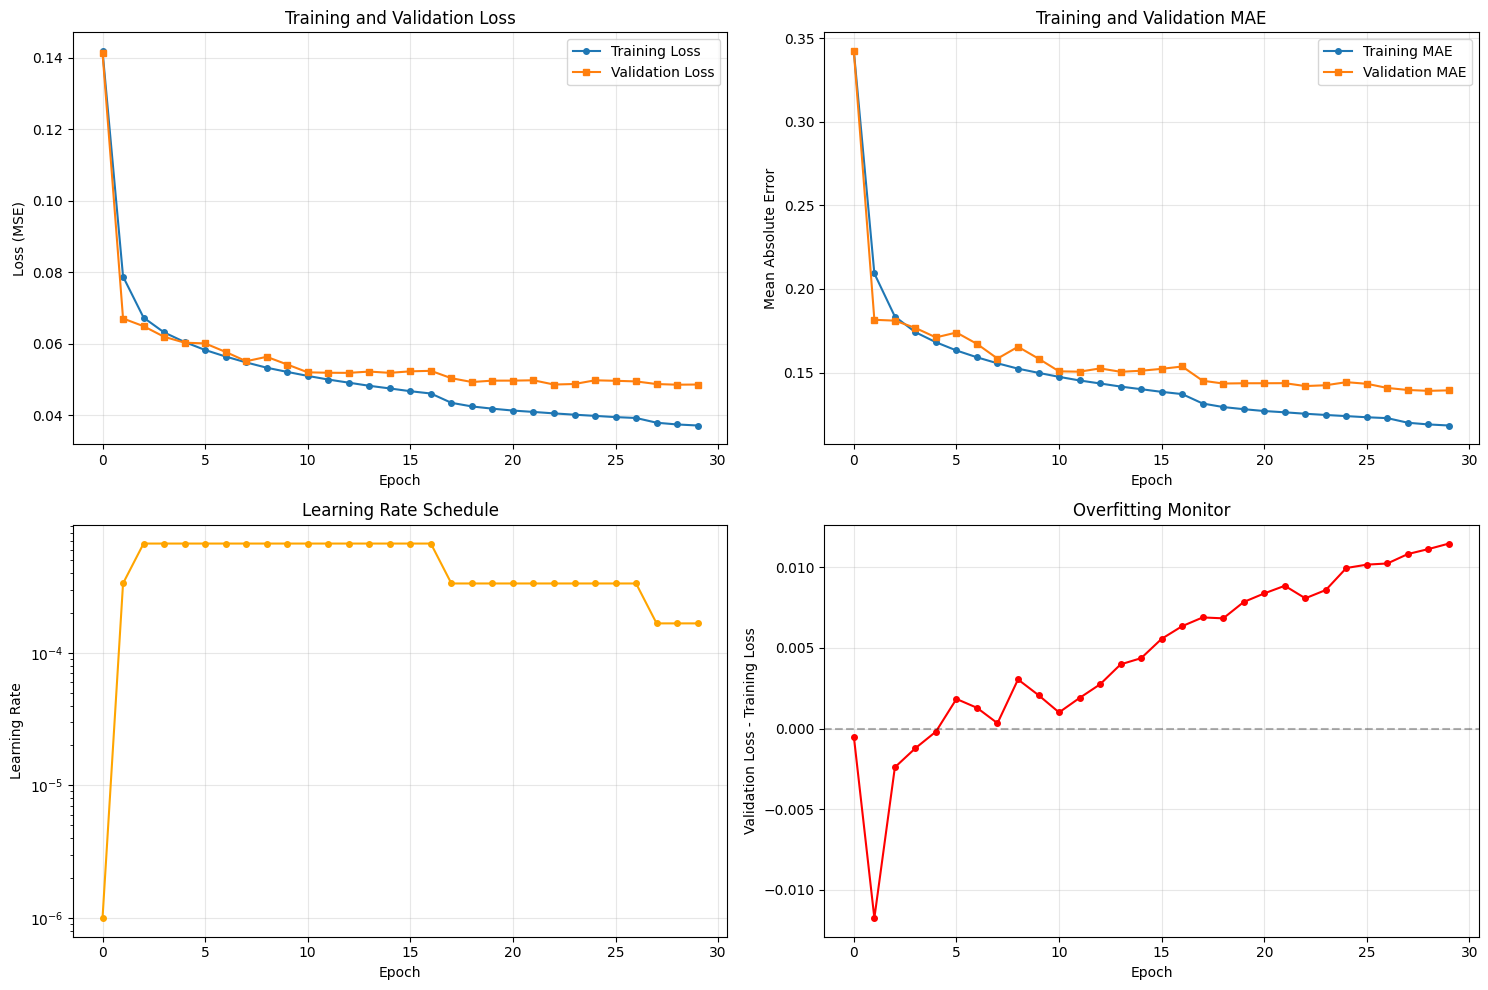

Training history plot saved as 'training_history_advanced.png'


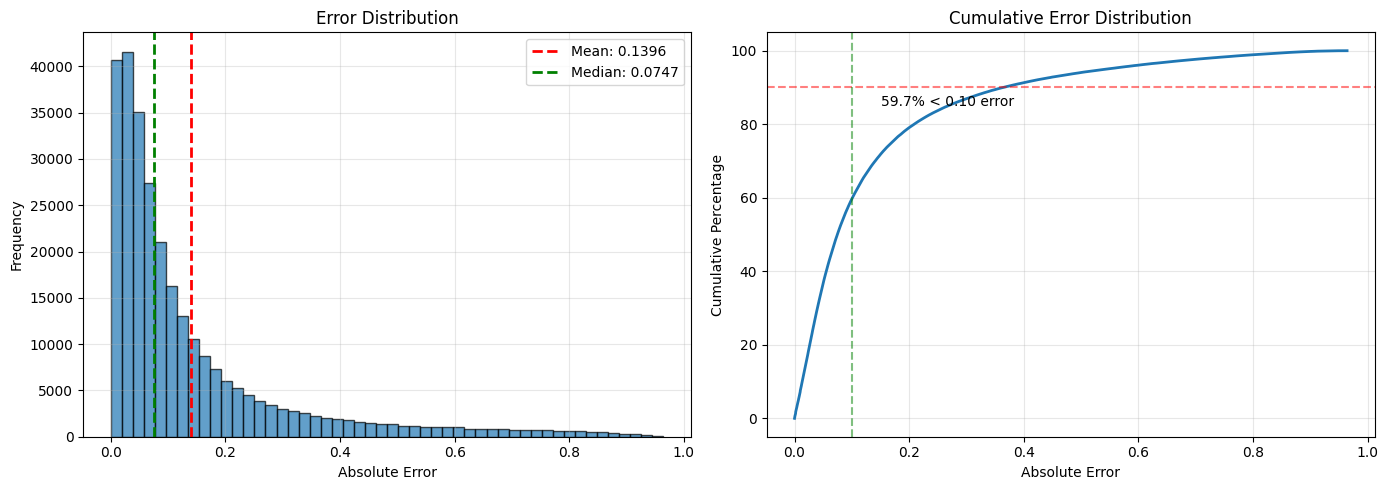

Error distribution plot saved as 'error_distribution.png'

STEP 8: Testing on sample positions...

Sample Position Evaluations:
FEN                                                                        True     Pred    Error
3r4/1pQ2p1k/p4pb1/1B5p/7P/P1P2P2/1PnrNK2/6R1...                          0.9657   0.6518   0.3139
6k1/1p3rp1/1PpBRp1p/2P5/p2P4/6PP/1n3PB1/6K1...                           0.9854   0.9364   0.0491
2kr4/1q4pp/1p2pp2/2p1n3/5B2/8/PPP1QPPP/5RK1...                           0.6427   0.6664   0.0237
rnbqkb1r/ppp1pppp/8/8/4Q3/8/PPPP1PPP/R1B1KBNR...                         0.5129   0.5030   0.0099
r2qr1k1/pp1n1ppp/2pbbp2/8/3N4/3BBQ1P/PPP2PP1/2KR3R...                    0.1041   0.3855   0.2814
3r4/R7/1N4k1/8/6pp/1PNp4/1PnK2PB/8...                                    0.8870   0.8820   0.0050
r2qkbnr/ppp3pp/5p2/3pp3/3P2b1/5PB1/PPP1P1PP/RN1QKB1R...                  0.5316   0.4287   0.1029
r3k2r/1bqpnp2/p1n1p2p/bp2P3/3P2p1/P5N1/1PB2PPP/R1BQNRK1...               0.7608   0.7083

In [20]:
CONFIG = {
    'csv_file': '/kaggle/input/positions-csv/positions.csv',
    'max_positions': 10000000,      # Use up to 1M positions
    'sample_frac': None,            # Or use sample_frac=0.1 for 10% of data
    'batch_size': 2048,
    'epochs': 30,
    'lr': 0.001,
    'use_advanced_features': True,
    'use_augmentation': True,
    'use_mixed_precision': True
}

print("Training Configuration:")
print(f"{'='*80}")
for key, value in CONFIG.items():
    print(f"  {key:<25}: {value}")
print(f"{'='*80}\n")

# Run the complete pipeline
model, history, test_metrics = complete_pipeline_advanced(**CONFIG)

# Export model and create documentation
if model is not None:
    print("\nExporting model and creating documentation...")
    export_model_onnx(model, 'nnue_model.onnx', CONFIG['use_advanced_features'])
    create_model_card(model, test_metrics, history, 'model_card.txt')

    print("\n✓ All done! Your improved NNUE model is ready to use.")

In [34]:
def interactive_position_analysis(model, use_advanced_features=True):
    """Interactive function to test specific positions."""
    print("\n" + "="*80)
    print("INTERACTIVE POSITION ANALYSIS")
    print("="*80)
    print("Enter FEN strings to evaluate (or 'quit' to exit)")
    print("Example: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
    print("="*80 + "\n")
    
    while True:
        fen = input("FEN: ").strip()

        if fen == "":
            print("Empty input received — exiting interactive mode.\n")
            break
        
        if fen.lower() in ['quit', 'exit', 'q']:
            break
        
        try:
            # Validate FEN
            board = chess.Board(fen)
            
            # Evaluate
            score = evaluate_position(model, fen, use_advanced_features, device)
            centipawns = score_to_centipawns(score)
            
            print(f"\n{'-'*80}")
            print(f"Position: {fen}")
            print(f"Score: {score:.4f} (probability)")
            print(f"Evaluation: {centipawns:+.2f} pawns")
            
            if score > 0.9:
                print("Assessment: Winning position for White")
            elif score > 0.7:
                print("Assessment: Clear advantage for White")
            elif score > 0.55:
                print("Assessment: Slight advantage for White")
            elif score > 0.45:
                print("Assessment: Roughly equal position")
            elif score > 0.3:
                print("Assessment: Slight advantage for Black")
            elif score > 0.1:
                print("Assessment: Clear advantage for Black")
            else:
                print("Assessment: Winning position for Black")
            
            print(f"{'-'*80}\n")
            
        except Exception as e:
            print(f"Error: {e}\n")


# Uncomment to run interactive testing
interactive_position_analysis(model, CONFIG['use_advanced_features'])


INTERACTIVE POSITION ANALYSIS
Enter FEN strings to evaluate (or 'quit' to exit)
Example: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1



FEN:  r1bq1rk1/pp2npbp/2n3p1/2p1p3/3pPP2/3P2N1/PPP1B1PP/R1BQ1RK1 w - - 0 11



--------------------------------------------------------------------------------
Position: r1bq1rk1/pp2npbp/2n3p1/2p1p3/3pPP2/3P2N1/PPP1B1PP/R1BQ1RK1 w - - 0 11
Score: 0.1022 (probability)
Evaluation: -3.77 pawns
Assessment: Clear advantage for Black
--------------------------------------------------------------------------------



FEN:  r1b3kr/ppp1Bp1p/1b6/n2P4/2p3q1/2Q2N2/P4PPP/RN2R1K1 w - - 1 20



--------------------------------------------------------------------------------
Position: r1b3kr/ppp1Bp1p/1b6/n2P4/2p3q1/2Q2N2/P4PPP/RN2R1K1 w - - 1 20
Score: 0.8250 (probability)
Evaluation: +2.69 pawns
Assessment: Clear advantage for White
--------------------------------------------------------------------------------



FEN:  8/p7/1p1k4/3p4/P2P4/1P6/4K3/8 w - - 0 1



--------------------------------------------------------------------------------
Position: 8/p7/1p1k4/3p4/P2P4/1P6/4K3/8 w - - 0 1
Score: 0.5059 (probability)
Evaluation: +0.04 pawns
Assessment: Roughly equal position
--------------------------------------------------------------------------------



FEN:  2kr3r/ppp1q1pp/2n5/3n1p2/1b1P4/4PQ2/PP1B1PPP/R3KBNR b KQ - 4 12



--------------------------------------------------------------------------------
Position: 2kr3r/ppp1q1pp/2n5/3n1p2/1b1P4/4PQ2/PP1B1PPP/R3KBNR b KQ - 4 12
Score: 0.3588 (probability)
Evaluation: -1.01 pawns
Assessment: Slight advantage for Black
--------------------------------------------------------------------------------



FEN:  


Empty input received — exiting interactive mode.



In [35]:
def test_benchmark_positions(model, use_advanced_features=True):
    """Test on well-known chess positions."""
    benchmark_positions = [
        ("Starting position", "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1", 0.5),
        ("Queen sacrifice", "r1bqkb1r/pppp1ppp/2n2n2/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 4 4", 0.85),
        ("Endgame - K+P vs K", "8/8/8/8/8/4k3/4P3/4K3 w - - 0 1", 0.95),
        ("Scholar's mate threat", "r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 0 4", 0.99),
        ("Equal position", "rnbqkb1r/ppp1pppp/5n2/3p4/3P4/5N2/PPP1PPPP/RNBQKB1R w KQkq - 2 3", 0.5),
        ("Black advantage", "r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/3P1N2/PPP2PPP/RNBQK2R w KQkq - 4 5", 0.3),
    ]
    
    print("\n" + "="*100)
    print("BENCHMARK POSITION TESTS")
    print("="*100)
    print(f"{'Position':<25} {'Expected':>10} {'Predicted':>10} {'Error':>10} {'Assessment':<30}")
    print("="*100)
    
    for name, fen, expected_score in benchmark_positions:
        pred_score = evaluate_position(model, fen, use_advanced_features, device)
        error = abs(expected_score - pred_score)
        centipawns = score_to_centipawns(pred_score)
        
        if pred_score > 0.7:
            assessment = "White advantage"
        elif pred_score > 0.55:
            assessment = "Slight White advantage"
        elif pred_score > 0.45:
            assessment = "Equal"
        elif pred_score > 0.3:
            assessment = "Slight Black advantage"
        else:
            assessment = "Black advantage"
        
        print(f"{name:<25} {expected_score:>10.4f} {pred_score:>10.4f} {error:>10.4f} {assessment:<30}")
    
    print("="*100 + "\n")


# Run benchmark tests
if model is not None:
    test_benchmark_positions(model, CONFIG['use_advanced_features'])


BENCHMARK POSITION TESTS
Position                    Expected  Predicted      Error Assessment                    
Starting position             0.5000     0.5240     0.0240 Equal                         
Queen sacrifice               0.8500     0.2557     0.5943 Black advantage               
Endgame - K+P vs K            0.9500     0.6294     0.3206 Slight White advantage        
Scholar's mate threat         0.9900     0.4280     0.5620 Slight Black advantage        
Equal position                0.5000     0.5088     0.0088 Equal                         
Black advantage               0.3000     0.4763     0.1763 Equal                         

